#https://www.kff.org/medicare/issue-brief/aiming-for-fewer-hospital-u-turns-the-medicare-hospital-readmission-reduction-program/

## BACKGROUND: DEFINING A HOSPITAL READMISSION
Generally speaking, a hospital readmission occurs when a patient is admitted to a hospital within a specified time period after being discharged from an earlier (initial) hospitalization. For Medicare, this time period is defined as 30 days, and includes hospital readmissions to any hospital, not just the hospital at which the patient was originally hospitalized. Medicare uses an “all-cause” definition of readmission, meaning that hospital stays within 30 days of a discharge from an initial hospitalization are considered readmissions, regardless of the reason for the readmission. This all-cause definition is used in calculating both the national average readmission rate and each hospital’s specific readmission rate. Starting in 2014, CMS began making an exception for planned hospitalizations (such as a scheduled coronary angioplasty) within the 30-day window; these are no longer counted as readmissions.

The current focus in the HRRP is on readmissions occurring after initial hospitalizations for selected conditions—namely, heart attack, heart failure, pneumonia, chronic obstructive pulmonary disease (COPD), elective hip or knee replacement, and coronary artery bypass graft (CABG). CMS also collects hospitals’ overall readmission rates (regardless of initial diagnoses), but these overall rates are not currently used in the HRRP to calculate readmissions penalties.

## Overview

### 1.) Data Cleansing
### 2.) Feature Engineering
### 3.) Feature Selection
### 4.) Model Fitting - Logistic Regression
### 5.) Model Accuracy Testing
### 6.) Model Optimization
### 7.) Gain Table & Lift Chart

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#enable IPython to display matplotlib graphs
%matplotlib inline
import csv

In [2]:
#read in training data set
data=pd.read_csv('diabetic_data_initial.csv')
data.head(10)
data.shape

(101766, 50)

In [3]:
data.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [5]:
data['weight'].value_counts()

?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64

In [6]:
data.readmitted.value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

# Label Creation & Minority Class Upsample

Since on readmission within 30 days from first discharge will count as an readmission and face penalty from CMS, we re-code 'readmitted' variable in to binary with 'NO' and '>30' being 0 and '<30' being 1. 

We can see from the new created label that there's relatively severe class imblance issue with original data. To avoid loss of information, we prefer to upsample the minority class to tackle class imblance instead of downsampling the majority class. 

In [7]:
#create label
data['label']=np.nan
data.loc[(data['readmitted']=='NO')|(data['readmitted']=='>30'),'label']=0
data['label']=data['label'].fillna(1)
data['label'].value_counts()

0.0    90409
1.0    11357
Name: label, dtype: int64

In [8]:
#upsample minority class
from sklearn.utils import resample

# Separate majority and minority classes
data_ma = data[data.label==0]
data_mi = data[data.label==1]
 
# Upsample minority class
data_mi_up = resample(data_mi, 
                   replace=True,     # sample with replacement
                   n_samples=90000,    # to match majority class
                   random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
data1 = pd.concat([data_ma, data_mi_up])
 
# Display new class counts
data1.label.value_counts()

#ref.: https://elitedatascience.com/imbalanced-classes

0.0    90409
1.0    90000
Name: label, dtype: int64

In [9]:
#after upsampling, need to reset index of data1:
data1=data1.reset_index()

# EDA



In [10]:
#Since all missing values in original dataset is marked with '?', we reverse it back to np.nan
data1=data1.replace('?', np.NaN)

In [11]:
#rows with missing value check:
data1.shape #(215235, 23)
nan_rows = lambda df: df[df.isnull().any(axis=1)]
nan_rows(data1).shape #many rows have missing value

(178703, 52)

In [12]:
#colomns with missing value check:
nan_cols = lambda df: df.columns[df.isnull().any()].tolist()
nan_cols(data1) #columns with missing value

['race',
 'weight',
 'payer_code',
 'medical_specialty',
 'diag_1',
 'diag_2',
 'diag_3']

# Missing Value Imputation

['race',
 'weight',
 'payer_code',
 'medical_specialty',
 'diag_1',
 'diag_2',
 'diag_3']
 
 All columns with missing value are categorical variables. We impute with mode value

In [13]:
impute_with_mode=nan_cols(data1)
for col in impute_with_mode:
    data1.loc[data1[col].isnull(), col]=data1[col].mode()[0]
nan_cols(data1) #cleared

[]

# Feature Engineering

['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']
       
Feature types:       

-multiclass categorical variables: 'race', 'gender', 'age', 'weight','admission_type_id', 'discharge_disposition_id', 'admission_source_id','time_in_hospital','payer_code', 'medical_specialty','max_glu_serum','A1Cresult', 'metformin','repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose', 'miglitol','troglitazone',
 'tolazamide', 'examide', 'citoglipton','insulin','glyburide-metformin', 'glipizide-metformin','glimepiride-pioglitazone',
 
('insulin', no need to regroup levels, 'glimepiride-pioglitazone' dropped)

-binary categorical variables:'change','diabetesMed', 

-numerical variables:'num_lab_procedures', 'num_procedures', 'num_medications','number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses', 

-meaning ambiguous variables:'diag_1', 'diag_2', 'diag_3', (consider dropping)


In [14]:
data1[ 'metformin'].value_counts()

No        147013
Steady     30625
Up          1682
Down        1089
Name: metformin, dtype: int64

In [15]:
#gender only has 3 records for 'Unknown', recode to female
data1['gender']=data1['gender'].astype('category')
data1.loc[data1['gender']=='Unknown/Invalid', 'gender']='Female'
data1['gender'].value_counts()

Female             97399
Male               83010
Unknown/Invalid        0
Name: gender, dtype: int64

In [16]:
#'age' level [10-20) and [0-10) is minority, we can combine these two into [0-20)
data1['age2']=np.nan
data1.loc[(data1['age']=='[10-20)')|(data1['age']=='[0-10)'),'age2']='[0-20)'
data1.loc[data1['age2'].isnull(),'age2']=data1['age']
data1['age2'].value_counts()


[70-80)     47277
[60-70)     39783
[80-90)     31565
[50-60)     28736
[40-50)     16864
[30-40)      6761
[90-100)     4989
[20-30)      3266
[0-20)       1168
Name: age2, dtype: int64

In [17]:
#'weight' has minority level in high weight, could combine minority levels into one:
data1['weight2']=np.nan
data1.loc[(data1['weight']=='[150-175)')|(data1['weight']=='[175-200)')|(data1['weight']=='>200'),'weight2']='>=150'
data1.loc[data1['weight2'].isnull(),'weight2']=data1['weight']
data1['weight2'].value_counts()

[75-100)     177064
[50-75)        1666
[100-125)      1117
[125-150)       222
[25-50)         157
[0-25)          100
>=150            83
Name: weight2, dtype: int64

In [18]:
#'admission_type_id' level 5,6,8 are all Null or Not Available data, we group them into one 'Not_Available'
data1['admission_type_id2']=np.nan
data1.loc[(data1['admission_type_id']==5)|(data1['admission_type_id']==6)|(data1['admission_type_id']==8),'admission_type_id2']='Not_Available'
data1.loc[data1['admission_type_id2'].isnull(),'admission_type_id2']=data1['admission_type_id']
data1['admission_type_id2'].value_counts()

1                97065
2                32854
3                32325
Not_Available    18128
7                   21
4                   16
Name: admission_type_id2, dtype: int64

In [19]:
#'discharge_disposition_id' level 18,25,26 are all 'Not Available', we group them into one 'Not_Available'
data1['discharge_disposition_id2']=np.nan
data1.loc[(data1['discharge_disposition_id']==18)|(data1['discharge_disposition_id']==25)|(data1['discharge_disposition_id']==26),'discharge_disposition_id2']='Not_Available'
data1.loc[data1['discharge_disposition_id2'].isnull(),'discharge_disposition_id2']=data1['discharge_disposition_id']
data1['discharge_disposition_id2'].value_counts()

1                99077
3                27979
6                24465
Not_Available     8526
22                5820
2                 4374
5                 2880
11                1642
4                 1541
7                 1232
23                 600
13                 548
14                 537
28                 494
15                 246
8                  203
9                   91
24                  90
12                  18
17                  14
16                  11
19                   8
10                   6
27                   5
20                   2
Name: discharge_disposition_id2, dtype: int64

In [20]:
#'discharge_disposition_id' also level frequency elbow drop at frequency level=1200, 
#we group level with frequency below 1200 into 1 level
levels_to_group = pd.DataFrame(data1['discharge_disposition_id2'].value_counts()[
        data1['discharge_disposition_id2'].value_counts()<1200]).index.tolist()
for level in levels_to_group:
    data1.loc[data1['discharge_disposition_id2']==level,'discharge_disposition_id2']='Other'
data1['discharge_disposition_id2'].value_counts()

1                99077
3                27979
6                24465
Not_Available     8526
22                5820
2                 4374
5                 2880
Other             2873
11                1642
4                 1541
7                 1232
Name: discharge_disposition_id2, dtype: int64

In [21]:
#'admission_source_id' has levels 9,15,17,20,21 all equal to 'Not_Available', we group them into one level
data1['admission_source_id2']=data1['admission_source_id']
levels_to_group = [9,15,17,20,21]
for level in levels_to_group:
    data1.loc[data1['admission_source_id2']==level,'admission_source_id2']='Not_Available'
data1['admission_source_id2'].value_counts()

7                104173
1                 51029
Not_Available     12230
4                  5352
6                  3753
2                  1900
5                  1506
3                   403
8                    25
22                   23
10                    8
25                    2
14                    2
11                    2
13                    1
Name: admission_source_id2, dtype: int64

In [22]:
#'admission_source_id' also has level frequency elbow drop at frequency level=1500, we group level with frequency below 1500 into 1 level
levels_to_group = pd.DataFrame(data1['admission_source_id2'].value_counts()[
        data1['admission_source_id2'].value_counts()<1200]).index.tolist()
for level in levels_to_group:
    data1.loc[data1['admission_source_id2']==level,'admission_source_id2']='Other'
data1['admission_source_id2'].value_counts()

7                104173
1                 51029
Not_Available     12230
4                  5352
6                  3753
2                  1900
5                  1506
Other               466
Name: admission_source_id2, dtype: int64

In [23]:
# 'time_in_hospital' has multiple levels, regroup minority levels into one level:
data1['time_in_hospital2']=data1['time_in_hospital']
levels_to_group = [9,10,11,12,13,14]
for level in levels_to_group:
    data1.loc[data1['time_in_hospital2']==level,'time_in_hospital2']='9+'
data1['time_in_hospital2'].value_counts()

3     30987
2     29096
4     25177
1     22266
9+    20829
5     18219
6     14029
7     11037
8      8769
Name: time_in_hospital2, dtype: int64

In [24]:
#group minority levels into one level
data1['payer_code'].value_counts()
data1['payer_code2']=data1['payer_code']
levels_to_group = pd.DataFrame(data1['payer_code2'].value_counts()[
        data1['payer_code2'].value_counts()<5000]).index.tolist()
for level in levels_to_group:
    data1.loc[data1['payer_code2']==level,'payer_code2']='Other'
data1['payer_code2'].value_counts()

MC       131350
Other     15946
HM        10734
SP         8490
BC         7525
MD         6364
Name: payer_code2, dtype: int64

In [25]:
#group minority levels into one level
data1['medical_specialty'].value_counts()
data1['medical_specialty2']=data1['medical_specialty']
levels_to_group = pd.DataFrame(data1['medical_specialty2'].value_counts()[
        data1['medical_specialty2'].value_counts()<5000]).index.tolist()
for level in levels_to_group:
    data1.loc[data1['medical_specialty2']==level,'medical_specialty2']='Other'
data1['medical_specialty2'].value_counts()

InternalMedicine          116189
Other                      23594
Family/GeneralPractice     13547
Emergency/Trauma           13386
Cardiology                  8169
Surgery-General             5524
Name: medical_specialty2, dtype: int64

In [26]:
#recode diebetes drug prescription related variables into two levels: Yes and No
prescriptions_to_recode=['metformin','repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide','glyburide',
'tolbutamide','pioglitazone','rosiglitazone','acarbose', 'miglitol','troglitazone', 'tolazamide', 'examide', 
'citoglipton','insulin','glyburide-metformin', 'glipizide-metformin','glimepiride-pioglitazone']
#leave out 'insulin' and drop 'glimepiride-pioglitazone' due to low variety
for var in prescriptions_to_recode:
    data1[var+'2']=data1[var]
    data1.loc[data1[var+'2']!='No', var+'2']='Yes'
#check recoded variables:    
recoded_prescriptions=[var+'2' for var in prescriptions_to_recode]
data1[recoded_prescriptions].head(10)

,metformin2,repaglinide2,nateglinide2,chlorpropamide2,glimepiride2,acetohexamide2,glipizide2,glyburide2,tolbutamide2,pioglitazone2,...,acarbose2,miglitol2,troglitazone2,tolazamide2,examide2,citoglipton2,insulin2,glyburide-metformin2,glipizide-metformin2,glimepiride-pioglitazone2
0,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
1,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,Yes,No,No,No
2,No,No,No,No,No,No,Yes,No,No,No,...,No,No,No,No,No,No,No,No,No,No
3,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,Yes,No,No,No
4,No,No,No,No,No,No,Yes,No,No,No,...,No,No,No,No,No,No,Yes,No,No,No
5,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,Yes,No,No,No
6,Yes,No,No,No,Yes,No,No,No,No,No,...,No,No,No,No,No,No,Yes,No,No,No
7,No,No,No,No,No,No,No,Yes,No,No,...,No,No,No,No,No,No,No,No,No,No
8,No,No,No,No,No,No,Yes,No,No,No,...,No,No,No,No,No,No,Yes,No,No,No
9,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,Yes,No,No,No


## Onehot Encode Categorical Variables

-multiclass categorical variables: 'race', 'gender', 'age', 'weight','admission_type_id', 'discharge_disposition_id', 'admission_source_id','time_in_hospital','payer_code', 'medical_specialty','max_glu_serum','A1Cresult', 'metformin','repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose', 'miglitol','troglitazone',
 'tolazamide', 'examide', 'citoglipton','insulin','glyburide-metformin', 'glipizide-metformin','glimepiride-pioglitazone',


In [27]:
data1.columns #data1['discharge_disposition_id2']

Index(['index', 'encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'weight', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'payer_code',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'label', 'age2', 'weight2', 'admission_type_id2',
       'discharge_disposit

In [28]:
cols_to_onehot=['race', 'gender', 'age2', 'weight2','admission_type_id2', 'discharge_disposition_id2', 'admission_source_id2',
               'payer_code2', 'medical_specialty2','max_glu_serum','A1Cresult']+recoded_prescriptions  #'time_in_hospital2',
onehotencoded=pd.get_dummies(data1[cols_to_onehot], prefix=cols_to_onehot)
onehotencoded.columns.tolist()


['race_AfricanAmerican',
 'race_Asian',
 'race_Caucasian',
 'race_Hispanic',
 'race_Other',
 'gender_Female',
 'gender_Male',
 'gender_Unknown/Invalid',
 'age2_[0-20)',
 'age2_[20-30)',
 'age2_[30-40)',
 'age2_[40-50)',
 'age2_[50-60)',
 'age2_[60-70)',
 'age2_[70-80)',
 'age2_[80-90)',
 'age2_[90-100)',
 'weight2_>=150',
 'weight2_[0-25)',
 'weight2_[100-125)',
 'weight2_[125-150)',
 'weight2_[25-50)',
 'weight2_[50-75)',
 'weight2_[75-100)',
 'admission_type_id2_1',
 'admission_type_id2_2',
 'admission_type_id2_3',
 'admission_type_id2_4',
 'admission_type_id2_7',
 'admission_type_id2_Not_Available',
 'discharge_disposition_id2_1',
 'discharge_disposition_id2_2',
 'discharge_disposition_id2_3',
 'discharge_disposition_id2_4',
 'discharge_disposition_id2_5',
 'discharge_disposition_id2_6',
 'discharge_disposition_id2_7',
 'discharge_disposition_id2_11',
 'discharge_disposition_id2_22',
 'discharge_disposition_id2_Not_Available',
 'discharge_disposition_id2_Other',
 'admission_source_i

## Normalize Numeric Variables


In [29]:
cols_to_norm = ['num_lab_procedures', 'num_procedures', 'num_medications','number_outpatient', 'number_emergency', 
                'number_inpatient','number_diagnoses','time_in_hospital']
data1[cols_to_norm] = data1[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [30]:
data1[cols_to_norm].describe()

,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,time_in_hospital
count,180409.000000,180409.000000,180409.000000,180409.000000,180409.000000,180409.000000,180409.000000,180409.000000
mean,0.325109,0.219979,0.192805,0.009469,0.003481,0.042371,0.436200,0.273806
std,0.148977,0.279980,0.101812,0.030256,0.015337,0.077270,0.124617,0.231683
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.236641,0.000000,0.125000,0.000000,0.000000,0.000000,0.333333,0.076923
50%,0.335878,0.166667,0.175000,0.000000,0.000000,0.000000,0.533333,0.230769
75%,0.427481,0.333333,0.250000,0.000000,0.000000,0.047619,0.533333,0.384615
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Feature Selection

In [31]:
#concatenate to obtain preliminary set of features
features=pd.concat([data1[cols_to_norm], onehotencoded],axis=1)
features.columns.tolist()

['num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'time_in_hospital',
 'race_AfricanAmerican',
 'race_Asian',
 'race_Caucasian',
 'race_Hispanic',
 'race_Other',
 'gender_Female',
 'gender_Male',
 'gender_Unknown/Invalid',
 'age2_[0-20)',
 'age2_[20-30)',
 'age2_[30-40)',
 'age2_[40-50)',
 'age2_[50-60)',
 'age2_[60-70)',
 'age2_[70-80)',
 'age2_[80-90)',
 'age2_[90-100)',
 'weight2_>=150',
 'weight2_[0-25)',
 'weight2_[100-125)',
 'weight2_[125-150)',
 'weight2_[25-50)',
 'weight2_[50-75)',
 'weight2_[75-100)',
 'admission_type_id2_1',
 'admission_type_id2_2',
 'admission_type_id2_3',
 'admission_type_id2_4',
 'admission_type_id2_7',
 'admission_type_id2_Not_Available',
 'discharge_disposition_id2_1',
 'discharge_disposition_id2_2',
 'discharge_disposition_id2_3',
 'discharge_disposition_id2_4',
 'discharge_disposition_id2_5',
 'discharge_disposition_id2_6',
 'discharge_disposition_id2_7'

In [53]:
initial_cols_to_model=['num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'time_in_hospital',
 'race_AfricanAmerican',
 'race_Asian',
 'race_Caucasian',
 'race_Hispanic',
 #'race_Other',
 #'gender_Female',
 'gender_Male',
 #'age2_[0-20)',
 'age2_[20-30)',
 'age2_[30-40)',
 'age2_[40-50)',
 'age2_[50-60)',
 'age2_[60-70)',
 'age2_[70-80)',
 'age2_[80-90)',
 'age2_[90-100)',
 'weight2_>=150',
 #'weight2_[0-25)',
 'weight2_[100-125)',
 'weight2_[125-150)',
 'weight2_[25-50)',
 'weight2_[50-75)',
 'weight2_[75-100)',
 'admission_type_id2_1',
 'admission_type_id2_2',
 'admission_type_id2_3',
 'admission_type_id2_4',
 'admission_type_id2_7',
 #'admission_type_id2_Not_Available',
 'discharge_disposition_id2_1',
 'discharge_disposition_id2_2',
 'discharge_disposition_id2_3',
 'discharge_disposition_id2_4',
 'discharge_disposition_id2_5',
 'discharge_disposition_id2_6',
 'discharge_disposition_id2_7',
 'discharge_disposition_id2_11',
 'discharge_disposition_id2_22',
 'discharge_disposition_id2_Not_Available',
 #'discharge_disposition_id2_Other',
 'admission_source_id2_1',
 'admission_source_id2_2',
 'admission_source_id2_4',
 'admission_source_id2_5',
 'admission_source_id2_6',
 'admission_source_id2_7',
 'admission_source_id2_Not_Available',
 #'admission_source_id2_Other',
 'medical_specialty2_Cardiology',
 'medical_specialty2_Emergency/Trauma',
 'medical_specialty2_Family/GeneralPractice',
 'medical_specialty2_InternalMedicine',
 #'medical_specialty2_Other',
 'medical_specialty2_Surgery-General',
 'max_glu_serum_>200',
 'max_glu_serum_>300',
 #'max_glu_serum_None',
 'max_glu_serum_Norm',
 'A1Cresult_>7',
 'A1Cresult_>8',
# 'A1Cresult_None',
 'A1Cresult_Norm'
]

#reserve as base: all the 'other' or 'no' or 'None' level, or minority level

In [54]:
#select significant features from initial set of features above and re-enter model training:

cols_to_drop=['admission_type_id2_4',
 'medical_specialty2_Surgery-General',
 'race_AfricanAmerican',
 'admission_type_id2_1',
 'race_Caucasian',
 'admission_type_id2_7',
 'discharge_disposition_id2_11',
 'num_procedures',
 'race_Asian',
 'race_Hispanic',
 'discharge_disposition_id2_1',
 'admission_type_id2_3',
              #first set
'weight2_[50-75)',
 'max_glu_serum_>300',
 'weight2_>=150',
 'weight2_[25-50)',
 'max_glu_serum_>200'

] #drop insignificant variables from previous model training results

cols_to_model=pd.concat([features[list(set(initial_cols_to_model)-set(cols_to_drop))],data1['label']], axis=1)
cols_to_model.columns.shape

(44,)

In [55]:
# VIF check for multicolinearity among variables before entering the final model:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# For each variable, calculate VIF and save in dataframe
# the input variable dataset needs to be in matrix form to enter vif function in statsmodel
X=cols_to_model.as_matrix()
vif = pd.DataFrame()
vif["VIF_factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif["features"] = cols_to_model.columns
vif

,VIF_factor,features
0,1.064628,A1Cresult_>7
1,1.046512,discharge_disposition_id2_5
2,4.170550,admission_source_id2_6
3,1.154817,number_outpatient
4,1.127917,discharge_disposition_id2_Not_Available
5,3.228563,age2_[20-30)
6,1.323923,medical_specialty2_Cardiology
7,1.544786,discharge_disposition_id2_3
8,1.099115,weight2_[125-150)
9,44.018090,admission_source_id2_1


In [56]:
# the rule of thumb is VIF >= 10 should be considered an indication of high colinearity:
cols_to_drop2=vif.loc[vif['VIF_factor']>=10, 'features'] #high multicolinearity, we drop them from final cols_to_model
# further drop the cols_to_drop2 from cols_to_model
cols_to_model=cols_to_model[list(set(cols_to_model.columns)-set(cols_to_drop2.tolist()))]
cols_to_model.columns.shape

(34,)

## Model Fitting - Logistic Regression

In [57]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [58]:
#train/test split for model training and accuracy testing:
selected = np.random.rand(len(cols_to_model)) < 0.70

cols_to_model_train = cols_to_model[selected] #training set

cols_to_model_test = cols_to_model[~selected] #testing set

In [59]:
cols_to_model_train.columns

Index(['A1Cresult_>7', 'discharge_disposition_id2_5', 'admission_source_id2_6',
       'number_outpatient', 'discharge_disposition_id2_Not_Available',
       'age2_[20-30)', 'medical_specialty2_Cardiology',
       'discharge_disposition_id2_3', 'weight2_[125-150)', 'num_medications',
       'age2_[30-40)', 'number_emergency', 'age2_[90-100)',
       'discharge_disposition_id2_7', 'discharge_disposition_id2_6',
       'number_inpatient', 'A1Cresult_>8', 'admission_source_id2_2',
       'medical_specialty2_Emergency/Trauma', 'A1Cresult_Norm',
       'discharge_disposition_id2_4', 'max_glu_serum_Norm',
       'weight2_[100-125)', 'admission_source_id2_4', 'num_lab_procedures',
       'time_in_hospital', 'medical_specialty2_InternalMedicine',
       'gender_Male', 'label', 'medical_specialty2_Family/GeneralPractice',
       'admission_source_id2_5', 'admission_type_id2_2',
       'discharge_disposition_id2_22', 'discharge_disposition_id2_2'],
      dtype='object')

In [60]:
#note sm.Logit() takes dataframe instead of series, need to convert label into dataframe instead of pd.Series
#all input should be in float64:
label_train=cols_to_model_train['label'].astype(float) #response variable
del cols_to_model_train['label']
for col in cols_to_model_train.columns:
    cols_to_model_train[col]=cols_to_model_train[col].astype(float)   

C:\Users\Dingding\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [61]:
#initiate logfit model 
logfit = sm.Logit(label_train, cols_to_model_train)
# fit the model
result = logfit.fit(maxiter=1000)

Optimization terminated successfully.
         Current function value: 0.659534
         Iterations 6


In [62]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:               126144
Model:                          Logit   Df Residuals:                   126111
Method:                           MLE   Df Model:                           32
Date:                Tue, 05 Dec 2017   Pseudo R-squ.:                 0.04849
Time:                        11:44:42   Log-Likelihood:                -83196.
converged:                       True   LL-Null:                       -87436.
                                        LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
A1Cresult_>7                                 -0.0775      0.032     -2.431      0.015      -0.140      -0.015
discharge_disposition_id2_5           

In [63]:
#return p-values of coefficients from fitted model:
pvalues=result.pvalues.to_frame()
pvalues.reset_index(inplace=True)
pvalues.columns=['features','pvalues']
pvalues


,features,pvalues
0,A1Cresult_>7,1.503850e-02
1,discharge_disposition_id2_5,1.005867e-81
2,admission_source_id2_6,3.849173e-04
3,number_outpatient,6.284218e-02
4,discharge_disposition_id2_Not_Available,8.899294e-16
5,age2_[20-30),6.267817e-01
6,medical_specialty2_Cardiology,4.006040e-53
7,discharge_disposition_id2_3,1.511199e-149
8,weight2_[125-150),1.493269e-02
9,num_medications,1.515114e-07


In [64]:
#drop all the features with p-value <=0.2 and refit the model with updated set of features:
cols_to_drop=pvalues.loc[pvalues['pvalues']>0.2, 'features'].tolist()
cols_to_drop

['age2_[20-30)']

In [65]:
#return coefficients from fitted model with coefficient absolute value greater than 1
coefs=result.params.to_frame()
coefs[abs(coefs[0])>1]

,0
number_emergency,4.651908
number_inpatient,6.079358
discharge_disposition_id2_22,1.304126


## Model Accuracy Testing
- Accuracy score: What percent of your predictions were correct?
- AUROC
- Confusion Metrix
- Sensitivity/Recall: What percent of the positive cases did you catch?
- Specificity: What percent of the negative cases did you catch?
- Precision: What percent of positive predictions were correct?
- F1 Score
- MCC score

In [66]:
#note sm.Logit() takes dataframe instead of series, need to convert label into dataframe instead of pd.Series
#all input should be in float64:
label_test=cols_to_model_test['label'].astype(float) #response variable
del cols_to_model_test['label']
for col in cols_to_model_test.columns:
    cols_to_model_test[col]=cols_to_model_test[col].astype(float)   

C:\Users\Dingding\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [67]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
accuracy_score(label_test, result.predict(cols_to_model_test).round())

0.60615498018980929

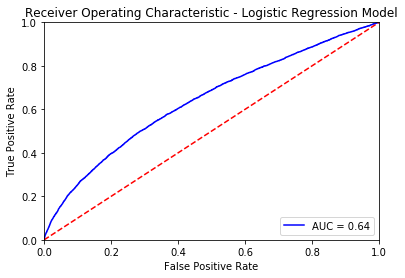

In [77]:
#ROC & AUC
# calculate the fpr and tpr for all thresholds of the classification
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = metrics.roc_curve(label_test, result.predict(cols_to_model_test))
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic - Logistic Regression Model')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#according to AUROC, it seems like a cut-off probability for bad buy at 0.5 is a good start

In [69]:
#create confusion metrix and put into dataframe:
print(metrics.confusion_matrix(label_test,result.predict(cols_to_model_test).round()))

confusion_metrix=pd.DataFrame(metrics.confusion_matrix(label_test,result.predict(cols_to_model_test).round()))
confusion_metrix.columns=['predicted_0','predicted_1'] #rename columns
confusion_metrix.index=['actual_0','actual_1'] #reset index value

TP=confusion_metrix.iloc[1,1]
FP=confusion_metrix.iloc[0,1]
FN=confusion_metrix.iloc[1,0]
TN=confusion_metrix.iloc[0,0]
confusion_metrix

[[18256  9066]
 [12306 14637]]


,predicted_0,predicted_1
actual_0,18256,9066
actual_1,12306,14637


In [70]:
#Recall/Sensitivity
recall=TP/(TP+FN)
print("Model prediction recall is {}.".format(recall))

Model prediction recall is 0.5432579890880749.


In [71]:
#Specificity
specificity = TN/(TN+FP)
print("Model prediction specificity is {}.".format(specificity))

Model prediction specificity is 0.668179489056438.


In [72]:
#Precision
precision=TP/(TP+FP)
print("Model prediction precision is {}.".format(precision))

Model prediction precision is 0.6175167700291102.


In [73]:
#F1 score
f1_score=2*(precision*recall)/(precision+recall)
print("Model prediction f1 score is {}.".format(f1_score))

Model prediction f1 score is 0.578012083876318.


## Model Optimization: Accuracy

In [168]:
# find optimal threshold for best expected gain:
#Expected Gain = TP*3+FN*(-1)+FP*(-5)+TN*0
thresholds=np.arange(0.0, 1.0, 0.05).tolist()
list_accuracy_scores=[]
#list_expected_gain=[]
i=0
for val in thresholds:
    list_accuracy_scores.append(accuracy_score(label_test, (result.predict(cols_to_model_test)-val+0.5).round()))
    confusion_metrix=pd.DataFrame(metrics.confusion_matrix(label_test,(result.predict(cols_to_model_test)-val+0.5).round()))
    TN=confusion_metrix.iloc[0,0]
    FN=confusion_metrix.iloc[1,0]
    FP=confusion_metrix.iloc[0,1]
    TP=confusion_metrix.iloc[1,1]
    #list_expected_gain.append(TP*3+FN*(-1)+FP*(-5)+TN*0)
print('The best accuracy score is {} at probability threshold {}'.format(
        max(list_accuracy_scores),list_accuracy_scores.index(max(list_accuracy_scores))*0.05)) #76.4% is the best accuracy rate at threshold of 
#max(list_expected_gain)

#concatenate into dataframe:
accuracy_by_threshold = pd.DataFrame(
    {'threshold': thresholds,
     'accuracy_score': list_accuracy_scores
     #'gain': list_expected_gain
    })
accuracy_by_threshold

The best accuracy score is 0.6061549801898093 at probability threshold 0.5


,accuracy_score,threshold
0,0.496508,0.00
1,0.496508,0.05
2,0.496508,0.10
3,0.496508,0.15
4,0.496508,0.20
5,0.496545,0.25
6,0.497190,0.30
7,0.506330,0.35
8,0.542044,0.40
9,0.590731,0.45


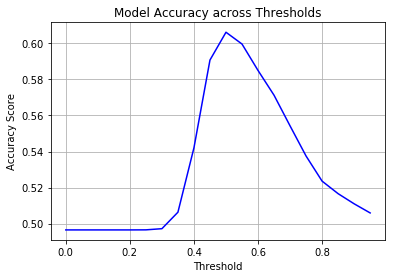

In [170]:
# Accuracy Plot 

plt.plot(accuracy_by_threshold['threshold'], accuracy_by_threshold['accuracy_score'], color='blue');
plt.title("Model Accuracy across Thresholds")
plt.xlabel("Threshold")
plt.ylabel("Accuracy Score")
plt.grid()
#savefig('uplift_mro_deciles.png')
plt.show()

## Gain Table & Lift Chart

- use the whole dateset for prediction using trained model 
- rank output probability scores and create 10 deciles
- calculate hit rate or response rate for each decile (number of positives fall in decile / total number of positives in population)
- plot the cumulative hit rate for every decile on a lift chart against a random 10 part split of population (each splitted part will have hit rate proportional to their weight in total population)

In [84]:
#get actual response, predictions for the complete dateset (population)
responses=cols_to_model['label']
del cols_to_model['label']
preds = result.predict(cols_to_model)

In [102]:
#concatenate responses and predictions into one dataframe, and sort into 10 deciles
decile_table=pd.DataFrame({
        'response': responses,
        'prediction': preds
    })
decile_table['pred_decile'] = pd.qcut(decile_table['prediction'], 10, labels=False)
decile_table.head(10)

,prediction,response,pred_decile
0,0.530226,0.0,6
1,0.405109,0.0,1
2,0.498530,0.0,5
3,0.386349,0.0,1
4,0.397265,0.0,1
5,0.373947,0.0,0
6,0.357724,0.0,0
7,0.393231,0.0,1
8,0.364154,0.0,0
9,0.486218,0.0,5


In [104]:
#sort decile_table by decile, and add class_prediction column using best threshold 0.5
decile_table=decile_table.sort_values('pred_decile', axis=0, ascending=True)
decile_table.head(10)

decile_table['class_prediction']=np.nan
decile_table.loc[decile_table['prediction']>=0.5, 'class_prediction']=1
decile_table.loc[decile_table['class_prediction'].isnull(), 'class_prediction']=0

decile_table.head(10)

,prediction,response,pred_decile,class_prediction
57629,0.382411,0.0,0,0.0
107033,0.360831,1.0,0,0.0
179524,0.352409,1.0,0,0.0
135566,0.334922,1.0,0,0.0
91215,0.377729,1.0,0,0.0
91204,0.381765,1.0,0,0.0
135585,0.336154,1.0,0,0.0
122199,0.341426,1.0,0,0.0
91191,0.358850,1.0,0,0.0
7952,0.330689,0.0,0,0.0


In [110]:
decile_table['pred_decile'].dtype

dtype('int64')

In [160]:
#calculate Gain Table:
perc_population=[]
cum_perc_population=[]
population_count=[]
perc_response=[]
cum_perc_response=[]
response_count=[]
last_decile_cpr=0
for decile in list(range(0,10)):
    
    perc_population.append(0.1)
    
    cum_perc_population.append(0.1*(1+decile))
    
    perc_response.append(decile_table.loc[decile_table['pred_decile']==decile, 'response'].sum()/decile_table['response'].sum())
    
    this_decile_cpr=last_decile_cpr + decile_table.loc[decile_table['pred_decile']==decile, 'response'].sum()/decile_table['response'].sum()
    
    cum_perc_response.append(this_decile_cpr)
    #cum_perc_response.append(cum_perc_response[len(cum_perc_response)-1] + decile_table.loc[
            #decile_table['pred_decile']==decile, 'response'].sum()/decile_table['response'].sum()) 
    last_decile_cpr=cum_perc_response[len(cum_perc_response)-1]
    
    population_count.append(decile_table[decile_table['pred_decile']==decile].shape[0])
    
    response_count.append(decile_table.loc[decile_table['pred_decile']==decile, 'response'].sum())


In [161]:
#create gain table    
gain_table=pd.DataFrame({
        'decile': list(range(0,10)),
        'population_count': population_count,
        'perc_population': perc_population,
        'cum_perc_population': cum_perc_population,
        'response_count': response_count,
        'cum_perc_response': cum_perc_response,
        'perc_response': perc_response
        
    })

gain_table

,cum_perc_population,cum_perc_response,decile,perc_population,perc_response,population_count,response_count
0,0.1,0.069056,0,0.1,0.069056,18041,6215.0
1,0.2,0.145767,1,0.1,0.076711,18041,6904.0
2,0.3,0.222478,2,0.1,0.076711,18047,6904.0
3,0.4,0.303811,3,0.1,0.081333,18045,7320.0
4,0.5,0.395033,4,0.1,0.091222,18035,8210.0
5,0.6,0.491633,5,0.1,0.096600,18036,8694.0
6,0.7,0.599711,6,0.1,0.108078,18043,9727.0
7,0.8,0.717089,7,0.1,0.117378,18039,10564.0
8,0.9,0.847711,8,0.1,0.130622,18046,11756.0
9,1.0,1.000000,9,0.1,0.152289,18036,13706.0


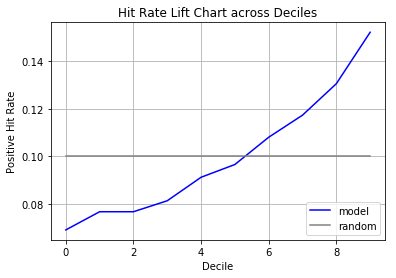

In [167]:
# Plot Lift Chart

plt.plot(gain_table['decile'], gain_table['perc_response'], color='blue');
plt.plot(gain_table['decile'], gain_table['perc_population'], color='grey');
plt.title("Hit Rate Lift Chart across Deciles")
plt.xlabel("Decile")
plt.ylabel("Positive Hit Rate")
# Adding the legend and showing the plot
plt.legend(['model','random'], loc='lower right')
plt.grid()
#savefig('uplift_mro_deciles.png')
plt.show()

## Alternative Model: Random Forest 

In [178]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation

C:\Users\Dingding\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [184]:
#Simple K-Fold cross validation. 10 folds.
#cv = cross_validation.KFold(len(cols_to_model_train), n_folds=10, shuffle=False)

In [172]:
# Create a random forest Classifier. 
rfc = RandomForestClassifier(n_jobs=2, random_state=0)

In [173]:
# Train the Classifier to take the training features and learn how they relate
rfc_fit=rfc.fit(cols_to_model_train, label_train)

In [185]:
# Use 10 fold CV to test stability of trained model
from sklearn.cross_validation import cross_val_score

cv_accuracy_scores = cross_val_score(rfc_fit, cols_to_model_train, label_train, cv=10, scoring='accuracy')
print(cv_accuracy_scores) 

[ 0.94768133  0.90471661  0.94205311  0.94791914  0.94482759  0.94609592
  0.94332144  0.94577024  0.94521525  0.94838659]


In [186]:
#model testing using testing set
accuracy_score(label_test, rfc_fit.predict(cols_to_model_test).round())

0.9584630977609877

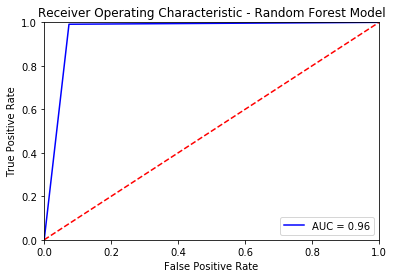

In [176]:
#ROC & AUC
# calculate the fpr and tpr for all thresholds of the classification
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = metrics.roc_curve(label_test, rfc_fit.predict(cols_to_model_test))
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic - Random Forest Model')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
